# <center>Data Mining for Big Data - Project</center>
---


*   Mohammad Poul Doust
*   Robin Khatri
*   Samaneh Zareian



# Prepare Environment

In [0]:
import sys
colab = 'google.colab' in sys.modules


In [0]:
#imports
import pandas as pd
import numpy as np
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import FrenchStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF, LatentDirichletAllocation
from math import floor
import pickle
from sklearn import preprocessing
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS 

import keras


from sklearn.decomposition import NMF, LatentDirichletAllocation

Using TensorFlow backend.


In [0]:
nltk.download('stopwords')
nltk.download('punkt')
stopword = set(stopwords.words('french'))
porter = PorterStemmer()
snowball_stemmer = FrenchStemmer()
print("french stop words: ", stopword)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
french stop words:  {'étés', 'serai', 'ayantes', 'étantes', 'étante', 'et', 'm', 'étaient', 'd', 'serez', 'étiez', 'je', 'étais', 'ta', 'serions', 'eurent', 'lui', 'nous', 'étant', 'il', 'fus', 'même', 'qu', 'est', 'eussent', 'soit', 'eussions', 'pas', 'sommes', 'eus', 'avait', 'son', 'avez', 'c', 'eûtes', 'aies', 'aurons', 'l', 'avais', 'mais', 'sont', 'sera', 'eûmes', 'ils', 'ayants', 'eusses', 'se', 'ces', 'n', 'ayez', 'soient', 'aura', 'eux', 'ayons', 'du', 'me', 'avaient', 'des', 'fusse', 'ai', 'dans', 'seraient', 'elle', 'furent', 'eut', 'ne', 'fût', 'suis', 'es', 'serait', 'aurai', 'soyons', 'eu', 'eue', 'fûmes', 'aurions', 'étées', 'les', 'ont', 'en', 'notre', 'mes', 'moi', 'mon', 'as', 'la', 'fut', 'tes', 'avec', 'ayante', 'fussiez', 'êtes', 'avions', 'aurait', 'e

# Prepare Dataset


In [0]:
path = "/content/EGC_dataset.csv"
df = pd.read_csv(path)
df.head()


,series,booktitle,year,title,abstract,authors,pdf1page,pdfarticle
0,Revue des Nouvelles Technologies de l'Information,EGC,2018,#Idéo2017 : une plateforme citoyenne dédiée à ...,Cette plateforme a pour objectif de permettre ...,"Claudia Marinica, Julien Longhi, Nader Hassine...",http://editions-rnti.fr/render_pdf.php?p1&p=10...,http://editions-rnti.fr/render_pdf.php?p=1002425
1,Revue des Nouvelles Technologies de l'Information,EGC,2018,A two level co-clustering algorithm for very l...,La classification croisée (co-clustering) est ...,"Marius Barctus, Marc Boullé, Fabrice Clérot",http://editions-rnti.fr/render_pdf.php?p1&p=10...,http://editions-rnti.fr/render_pdf.php?p=1002372
2,Revue des Nouvelles Technologies de l'Information,EGC,2018,ALGeoSPF: Un modèle de factorisation basé sur ...,La recommandation de points d'intérêts est dev...,"Jean-Benoît Griesner, Talel Abdesssalem, Huber...",http://editions-rnti.fr/render_pdf.php?p1&p=10...,http://editions-rnti.fr/render_pdf.php?p=1002380
3,Revue des Nouvelles Technologies de l'Information,EGC,2018,Analyse des sentiments à partir des commentair...,L'analyse des sentiments est un processus pend...,"Abdeljalil Elouardighi, Mohcine Maghfour, Hafd...",http://editions-rnti.fr/render_pdf.php?p1&p=10...,http://editions-rnti.fr/render_pdf.php?p=1002397
4,Revue des Nouvelles Technologies de l'Information,EGC,2018,Analyse en rôles sémantiques pour le résumé au...,Cet article présente une approche visant à ext...,"Elyase Lassouli, Yasmine Mesbahi, Camille Prad...",http://editions-rnti.fr/render_pdf.php?p1&p=10...,http://editions-rnti.fr/render_pdf.php?p=1002384


In [0]:
def tokenize(text):
    # clean false data
    if not isinstance(text, str):
      return
    words = word_tokenize(text) #split words
    

    words = [w.lower() for w in words if w.isalpha()] 
    words =[w for w in words if  not w in stopword]
    # stemmed = [snowball_stemmer.stem(w) for w in words]
    # # stemmed = [porter.stem(w) for w in words]
    
    stemmed = words
    # # try lemmatizing instead?
    stemmed = ' '.join(w for w in stemmed)
    return stemmed
    # return text

In [0]:
df['abstract_cleaned'] = df.abstract.map(tokenize)
df.head()

,series,booktitle,year,title,abstract,authors,pdf1page,pdfarticle,abstract_cleaned
0,Revue des Nouvelles Technologies de l'Information,EGC,2018,#Idéo2017 : une plateforme citoyenne dédiée à ...,Cette plateforme a pour objectif de permettre ...,"Claudia Marinica, Julien Longhi, Nader Hassine...",http://editions-rnti.fr/render_pdf.php?p1&p=10...,http://editions-rnti.fr/render_pdf.php?p=1002425,cette plateforme a objectif permettre citoyens...
1,Revue des Nouvelles Technologies de l'Information,EGC,2018,A two level co-clustering algorithm for very l...,La classification croisée (co-clustering) est ...,"Marius Barctus, Marc Boullé, Fabrice Clérot",http://editions-rnti.fr/render_pdf.php?p1&p=10...,http://editions-rnti.fr/render_pdf.php?p=1002372,classification croisée technique permet exista...
2,Revue des Nouvelles Technologies de l'Information,EGC,2018,ALGeoSPF: Un modèle de factorisation basé sur ...,La recommandation de points d'intérêts est dev...,"Jean-Benoît Griesner, Talel Abdesssalem, Huber...",http://editions-rnti.fr/render_pdf.php?p1&p=10...,http://editions-rnti.fr/render_pdf.php?p=1002380,recommandation points devenue caractéristiquee...
3,Revue des Nouvelles Technologies de l'Information,EGC,2018,Analyse des sentiments à partir des commentair...,L'analyse des sentiments est un processus pend...,"Abdeljalil Elouardighi, Mohcine Maghfour, Hafd...",http://editions-rnti.fr/render_pdf.php?p1&p=10...,http://editions-rnti.fr/render_pdf.php?p=1002397,sentiments processus pendant lequel polarité p...
4,Revue des Nouvelles Technologies de l'Information,EGC,2018,Analyse en rôles sémantiques pour le résumé au...,Cet article présente une approche visant à ext...,"Elyase Lassouli, Yasmine Mesbahi, Camille Prad...",http://editions-rnti.fr/render_pdf.php?p1&p=10...,http://editions-rnti.fr/render_pdf.php?p=1002384,cet article présente approche visant extraire ...


# Exploratory Data Analysis 

## How many authors we have ?


In [0]:
def get_unique_authors(df):
  authors = df.authors.str.split(',')
  result =  [list(map(str.strip, sublist)) for sublist in authors for item in sublist] 
  flattened_authors = [item for sublist in result for item in sublist]
  unique_authors = np.unique(np.array(flattened_authors))
  return unique_authors, authors


In all years:

In [0]:
unique_authors, authors = get_unique_authors(df)
print(unique_authors)
num_classes = len(unique_authors)
print("# of unique authors in all years: ", num_classes)

['Abdelaziz Bensrhair' 'Abdelaziz Marzak' 'Abdelfettah Feliachi' ...
 'Éric Sardet' 'Éric Trupin' 'Étienne-Cuvelier']
# of unique authors in all years:  2007


Unique authors per year:

year:  2004  authors:  196
year:  2005  authors:  212
year:  2006  authors:  241
year:  2007  authors:  223
year:  2008  authors:  265
year:  2009  authors:  197
year:  2010  authors:  277
year:  2011  authors:  243
year:  2012  authors:  168
year:  2013  authors:  154
year:  2014  authors:  227
year:  2015  authors:  181
year:  2016  authors:  231
year:  2017  authors:  199
year:  2018  authors:  225
average Autors:  215.93333333333334


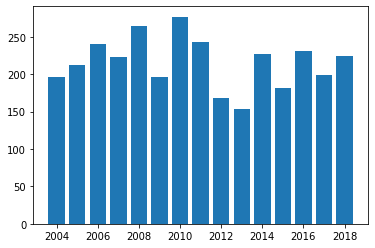

In [0]:
years = np.unique(df.year)
frequency_dic = {}
to_be_averaged = 0
for year in years:
  df_year = df.loc[df.year==year]
  uni_auth, auth = get_unique_authors(df_year)
  len_unique_authors = len(uni_auth)
  print("year: ", year, " authors: ", len_unique_authors)
  to_be_averaged += len_unique_authors
  frequency_dic[year] = len_unique_authors

plt.bar(list(frequency_dic.keys()), list(frequency_dic.values()), align='center')
# plt.show()
plt.savefig("authors_dis.png")
print("average Autors: ", to_be_averaged / len(years))


## Are there authors that usually publish together?

In [0]:
def one_hot_authors(row, encoder, num_classes):
  row = list(map(str.strip, row))
  encoding = encoder.transform(row)
  one_hot =  keras.utils.to_categorical(encoding, num_classes= num_classes)
  result = np.sum(one_hot,axis=0)
  # result = pd.DataFrame(result)
  return result



In [0]:
le = preprocessing.LabelEncoder()
le.fit(unique_authors)

LabelEncoder()

In [0]:
encoding_matrx = []
for items in authors.iteritems(): 
    res =  one_hot_authors(items[1], le, num_classes)
    encoding_matrx.append(res)

encoding_matrx = np.array(encoding_matrx)

columns_name = [i for i in range(num_classes)]
columns_name = le.inverse_transform(columns_name)
df_encoded_as_columns = pd.DataFrame(encoding_matrx, columns= columns_name)
encoded_dataset = pd.concat([df, df_encoded_as_columns], axis=1)
encoded_dataset.to_csv("encoded_dataset.csv",  encoding='utf-8')

(1269, 584)
(1269, 198)
(1269, 99)
(1269, 56)
(1269, 37)
(1269, 29)
(1269, 19)
(1269, 11)
(1269, 6)


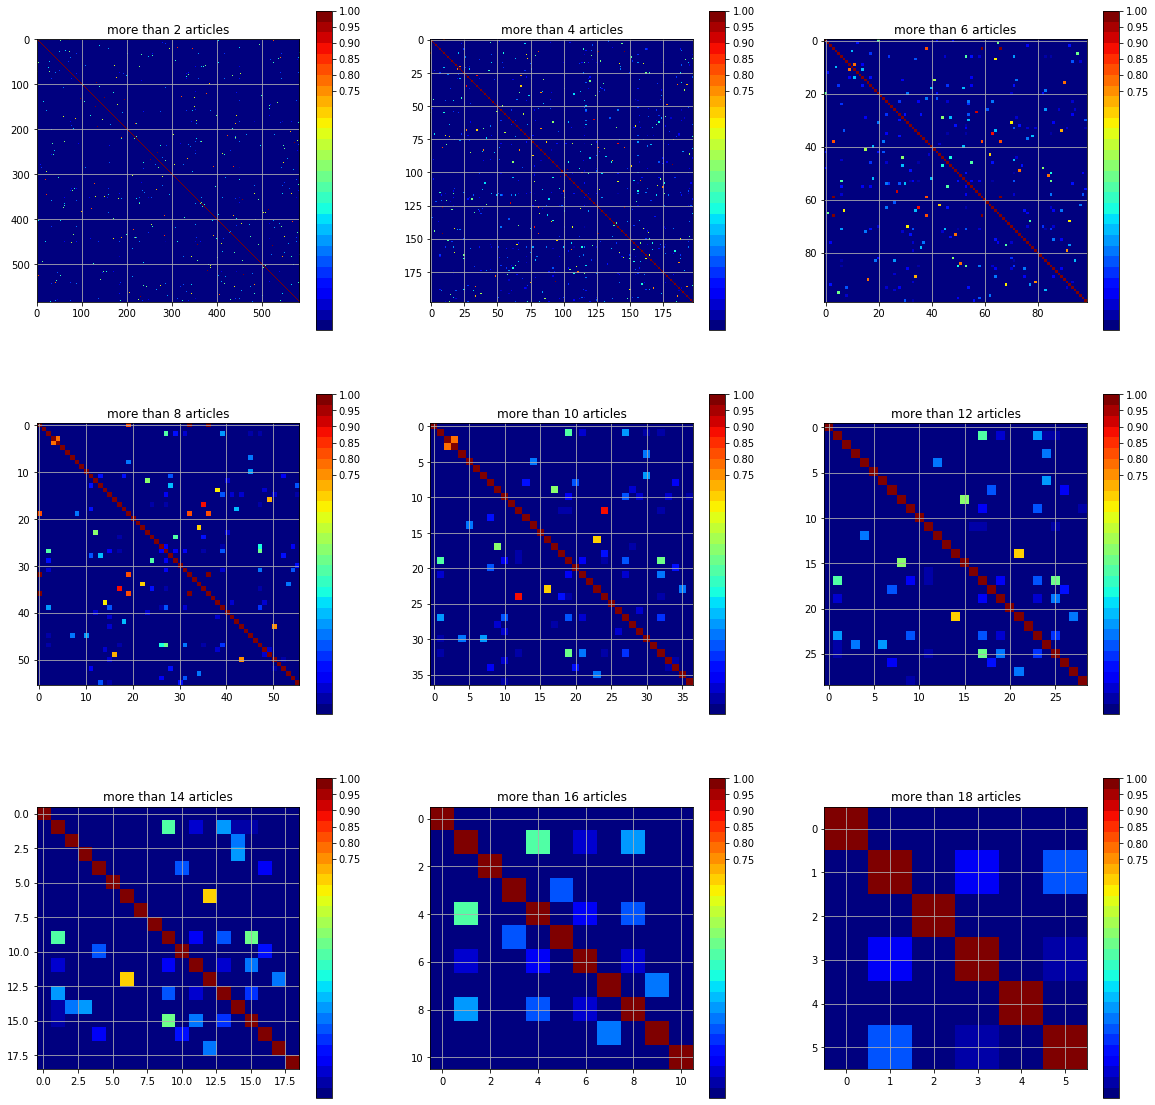

In [0]:
from matplotlib import pyplot as plt
from matplotlib import cm as cm

threshold_frequency_dic = {}
# fig = plt.figure()
fig = plt.figure(figsize=(20, 20))
for i in range (0, 9):
  df_authors_filtered = df_encoded_as_columns.loc[:, (df_encoded_as_columns.sum(axis=0) >= ((i+1)*2) )]
  print(df_authors_filtered.shape)
  index = ((i+1)*2)
  threshold_frequency_dic[index] =df_authors_filtered.shape[1]
  c = df_authors_filtered.corr().abs()
  # ax1 = subplot(4,1,i)
  ax1 = fig.add_subplot(3,3,i+1)
  ax1.title.set_text("more than " + str(((i+1)*2)) + " articles")
  cmap = cm.get_cmap('jet', 30)
  cax = ax1.imshow(c, interpolation="nearest", cmap=cmap)
  ax1.grid(True)
  # Add colorbar, make sure to specify tick locations to match desired ticklabels
  fig.colorbar(cax, ticks=[.75,.8,.85,.90,.95,1])
  # plt.show()

plt.savefig("coorelation.png")

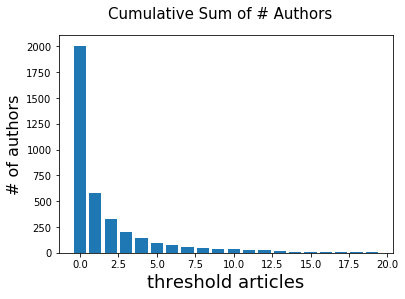

In [0]:
from matplotlib import pyplot as plt
from matplotlib import cm as cm

fig = plt.figure()
threshold_frequency_dic = {}
for i in range (0, 20):
  df_authors_filtered = df_encoded_as_columns.loc[:, (df_encoded_as_columns.sum(axis=0) >= i+1)]
  threshold_frequency_dic[i] =df_authors_filtered.shape[1]

plt.bar(list(threshold_frequency_dic.keys()), list(threshold_frequency_dic.values()),)
# plt.show()
fig.suptitle('Cumulative Sum of # Authors', fontsize=15)
plt.xlabel('threshold articles', fontsize=18)
plt.ylabel('# of authors', fontsize=16)
plt.savefig("cumsum_authors.png")

In [0]:
threshold_frequency_dic

{0: 2007,
 1: 584,
 2: 328,
 3: 198,
 4: 139,
 5: 99,
 6: 73,
 7: 56,
 8: 45,
 9: 37,
 10: 32,
 11: 29,
 12: 23,
 13: 19,
 14: 12,
 15: 11,
 16: 9,
 17: 6,
 18: 4,
 19: 4}

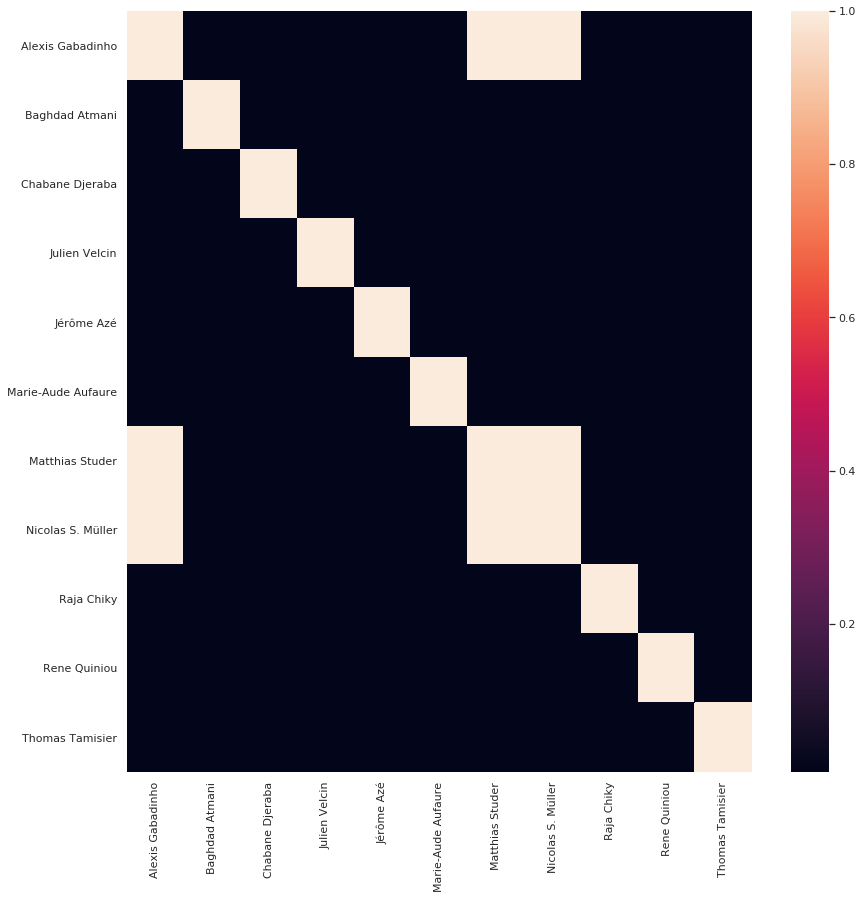

In [0]:
df_authors_filtered = df_encoded_as_columns.loc[:, (df_encoded_as_columns.sum(axis=0) == 8 )]
c = df_authors_filtered.corr().abs()
# print(c)
import seaborn as sns

sns.set(rc={'figure.figsize':(14,14)})
corr = c
sns_plot = sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
fig = sns_plot.get_figure()
fig.savefig("output.png")

In [0]:
def get_duplications(df):
    to_delete = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            to_delete.add((cols[i], cols[j]))
    return to_delete

def correlation_ordered(df):
    authors_corr = df.corr().abs().unstack()
    labels_to_drop = get_duplications(df)
    authors_corr = authors_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return authors_corr
print("Top Correlation")
top_correlation = correlation_ordered(df_encoded_as_columns)


Top Correlation


In [0]:
top_correlation[:4]

Bruno Bouzy        Guillaume Chaslot    1.0
Lyes Benamsili     Philippe Muller      1.0
Enric Ripoll       Tomàs Aluja-Banet    1.0
François Scharffe  Oscar Corcho         1.0
dtype: float64

In [0]:
top_correlation.to_csv("correlation.csv")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


In [0]:
# df_top_correlation = pd.DataFrame(top_correlation)
df_top_correlation = top_correlation.reset_index()
df_top_correlation = pd.DataFrame(df_top_correlation)
df_top_correlation.columns = ['Author_1', 'Author_2', 'Corr']
print(df_top_correlation.loc[df_top_correlation['Corr'] < 1] [:50])


                        Author_1                    Author_2      Corr
1009              Erick Stattner             Martine Collard  0.925454
1010              Brigitte Safar             Chantal Reynaud  0.894074
1011            Frédéric Flouvat      Nazha Selmaoui-Folcher  0.869212
1012             Badre Belabbess                Olivier Curé  0.865683
1013                 Jérémy Lhez                Olivier Curé  0.865683
1014        Jean-Benoît Griesner           Talel Abdesssalem  0.865683
1015               Hubert Naacke        Jean-Benoît Griesner  0.865683
1016         Chantal Soulé-Dupuy  Nathalie Vallès-Parlangeau  0.865683
1017             Claude Pasquier               Jérémy Sanhes  0.865683
1018               André Péninou              Florence Sedes  0.865683
1019             Alban Mancheron            Lionel Vinceslas  0.865683
1020            Thierry Artières           Trinh Minh Tri Do  0.865683
1021            Alexandre Aussem              Marilys Corbex  0.865683
1022  

## Articles published through time

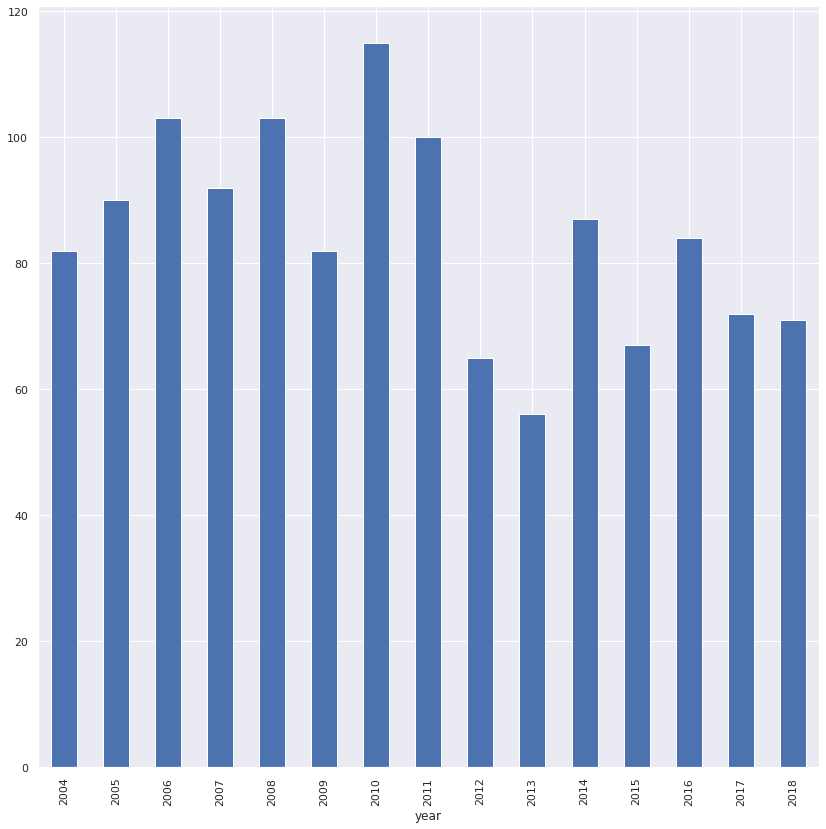

In [0]:
df.groupby('year').count()['booktitle'].plot(kind='bar')


average articles per year:  84.6


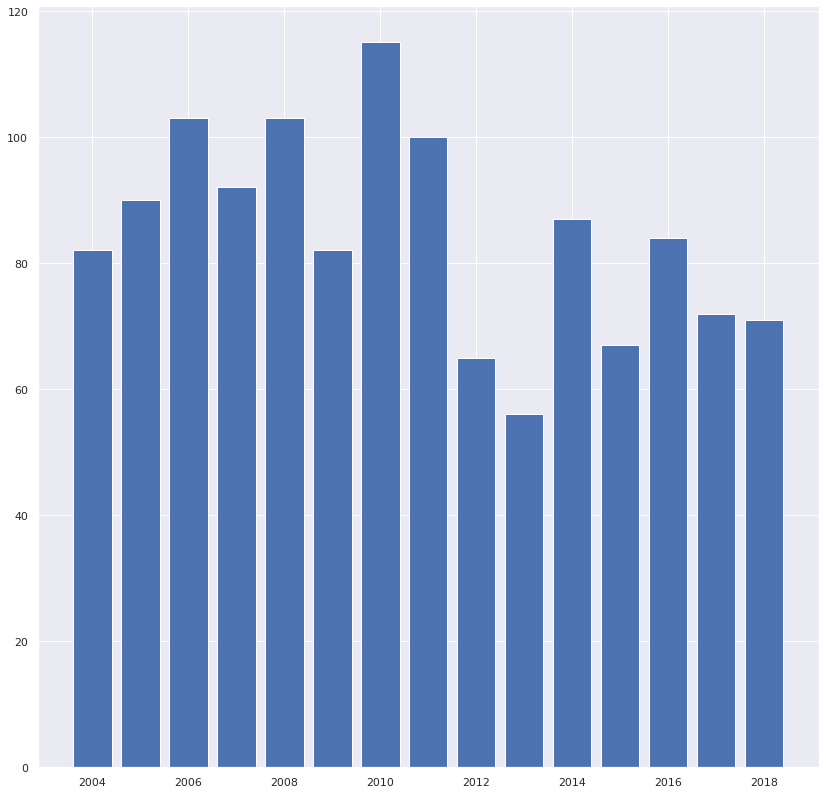

In [0]:
grouped_articles = df.groupby('year').count()['booktitle']
grouped_articles = grouped_articles.reset_index()
plt.bar(grouped_articles.year.values, grouped_articles.booktitle.values, align='center')
plt.savefig("articles_dist.png")
print("average articles per year: ",  grouped_articles.booktitle.values.mean())


## Is it possible to predict at least one author based on abstract and/or extra information from the article

## What are the top topics in all dataset, per authors, per year ?

Year 2018


In [0]:
def print_top_words(model, feature_names, n_top_words):
    topic_words = ""
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        topic_words += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()
    return topic_words

def get_topics(df, n_topics = 10, n_words= 20, stopwords = 'english'):
  tfidf = TfidfVectorizer(max_features = 1000, stop_words=stopwords)
  df = df.dropna()
  list_text = df.to_list()
  result = tfidf.fit_transform(list_text)
  lda = LatentDirichletAllocation(n_components= n_topics, learning_method='online',
                                learning_offset=50.)
  lda.fit(result)
  tf_feature_names = tfidf.get_feature_names()
  topic_words = print_top_words(lda, tf_feature_names, n_words)
  return topic_words


In [0]:
df_2018 = df[df.year == 2018]
topic_text = get_topics(df_2018.abstract, n_topics = 5, n_words= 3, stopwords =stopword)

Topic #0: données réel espace
Topic #1: données modèles approche
Topic #2: données recherche similarité
Topic #3: informations analyse donné
Topic #4: modèle événements vie



In [0]:
df_2018 = df[df.year == 2018]
# df_2018 = df
topic_text = get_topics(df_2018.abstract_cleaned, n_topics = 3, n_words=400 , stopwords =stopword)
topic_text

Topic #0: données méthode article sémantique méthodes événements ainsi recherche être entre cet modèles proposons approche modèle peuvent liens papier relations règles variantes deux météorologiques approches particulier reposent changement santé résultats propose variables textes jeux classes informations thématique peut problème recommandation présente scientifiques fournies texte basée produits corpus villes variées articles linguistique dont théorie présentons trouvés classification édition tableau permettant cette lorsque prédiction ressources labels variable clusters séquences terrain réseau untreillis faciliter similarité trois textuelle celles tâche sélectionner réduisant moyen via fouille avant évaluées réseaux tests voyage ensembles france systèmes online ensemble évitable raison disponible chaque utilisateur différentes inventaires ntgsp certains façon référence majeur lien séquencesen shift mêmes nouvelle appliquée vérité vie valeurajoutée utilisons devenue négatifs proposé

'données méthode article sémantique méthodes événements ainsi recherche être entre cet modèles proposons approche modèle peuvent liens papier relations règles variantes deux météorologiques approches particulier reposent changement santé résultats propose variables textes jeux classes informations thématique peut problème recommandation présente scientifiques fournies texte basée produits corpus villes variées articles linguistique dont théorie présentons trouvés classification édition tableau permettant cette lorsque prédiction ressources labels variable clusters séquences terrain réseau untreillis faciliter similarité trois textuelle celles tâche sélectionner réduisant moyen via fouille avant évaluées réseaux tests voyage ensembles france systèmes online ensemble évitable raison disponible chaque utilisateur différentes inventaires ntgsp certains façon référence majeur lien séquencesen shift mêmes nouvelle appliquée vérité vie valeurajoutée utilisons devenue négatifs proposée permet 

In [0]:
df_2018 = df_2018.dropna()


In [0]:
wordcloud = WordCloud(width=1600, height=800, max_words=100, stopwords=['contrainte', 'variable', 'outil', 'type', 'domaine', 'cc', 'document', 'rôle', 'utilisateur','pase', 'algorithme', 'variante', 'nécessaire', 'of', 'ainsi','textes', 'ensemble', 'plus','requête', 'problème', 'deux', 'carte', 'basé', 'nouvelle', 'critère', 'résultats', 'résultat', 'celle', 'basée', 'base', 'article', 'données', 'donnée','méthode', 'approche','déjà', 'cependant', 'cet', 'cette', 'système','performance', 'particulier', 'spécifique','spécifiques', 'papier', 'recherche', 'autres', 'entre', 'proposée', 'proposons', 'autre', 'être','modèle', 'moyen'], background_color="white").generate(topic_text)

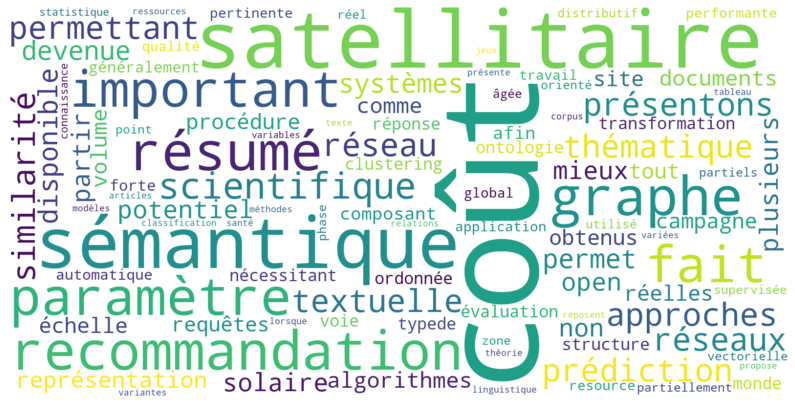

In [0]:
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
wordcloud.to_file("year_2018_wc.png")

## Frequent groups of authors




In [0]:
from mlxtend.frequent_patterns import apriori
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori

In [0]:
df_authors_filtered = df_encoded_as_columns.loc[:, (df_encoded_as_columns.sum(axis=0) >= 10 )]
df_authors_filtered.shape

(1269, 37)

In [0]:
auth_list = df.authors.to_list()
auth_list = [ group.split(',') for group in auth_list]
dataset = [  [s.strip() for s in group] for group in auth_list]
dataset

[['Claudia Marinica',
  'Julien Longhi',
  'Nader Hassine',
  'Abdulhafiz Alkhouli',
  'Boris Borzic'],
 ['Marius Barctus', 'Marc Boullé', 'Fabrice Clérot'],
 ['Jean-Benoît Griesner',
  'Talel Abdesssalem',
  'Hubert Naacke',
  'Pierre Dosne'],
 ['Abdeljalil Elouardighi',
  'Mohcine Maghfour',
  'Hafdalla Hammia',
  'Fatima-Zahra Aazi'],
 ['Elyase Lassouli', 'Yasmine Mesbahi', 'Camille Pradel', 'Damien Sileo'],
 ['Marwan Batrouni', 'Aurélie Bertaux', 'Christophe Nicolle'],
 ['Romain Billot',
  'Sofian Berrouiguet',
  'Mark Larsen',
  'Michel Walter',
  'Jorge López Castroman',
  'Enrique Baca-García',
  'Philippe Courtet',
  'Philippe Lenca'],
 ['Vincent Lemaire', 'Oumaima Alaoui Ismaili'],
 ['Khalil Laghmari', 'Christophe Marsala', 'Mohammed Ramdani'],
 ['Emmanuelle Claeys', 'Pierre Gançarski', 'Myriam Maumy-Bertrand'],
 ['Fosca Giannotti'],
 ['Denis Maurel', 'Jérémie Sublime', 'Sylvain Lefebvre'],
 ['Bastien Latard',
  'Jonathan Weber',
  'Germain Forestier',
  'Michel Hassenforder']

In [0]:
abstract_list = df.abstract_cleaned.to_list()
# abstract_list =  [ article.split(',') for article in abstract_list]
abstract_list = [  [s for s in str(article).split()] for article in abstract_list]
# dataset = [  [s.strip() for s in group] for group in auth_list]


In [0]:
# abstract_list
te = TransactionEncoder()
te_ary = te.fit(abstract_list).transform(abstract_list)
df_apriori = pd.DataFrame(te_ary, columns=te.columns_)
# df_apriori

In [0]:
frequent_authors = apriori(df_apriori, min_support=0.04, use_colnames=True)
frequent_authors['length'] = frequent_authors['itemsets'].apply(lambda x: len(x))

frequent_authors = frequent_authors[ (frequent_authors['length'] >= 2)  &
                   (frequent_authors['support'] >= 0.08)]
frequent_authors

,support,itemsets,length
167,0.102443,"(article, a)",2
169,0.106383,"(cet, a)",2
174,0.113475,"(données, a)",2
183,0.080378,"(proposons, a)",2
200,0.085894,"(données, ainsi)",2
...,...,...,...
664,0.082742,"(article, résultats, cet)",3
685,0.092199,"(article, données, proposons)",3
696,0.081954,"(cette, cet, données)",3
714,0.096139,"(données, cet, proposons)",3


In [0]:
te = TransactionEncoder()
te_ary = te.fit(dataset).transform(dataset)
df_apriori = pd.DataFrame(te_ary, columns=te.columns_)
df_apriori

,Abdelaziz Bensrhair,Abdelaziz Marzak,Abdelfettah Feliachi,Abdelghani Bellaachia,Abdelhadi Fennan,Abdelhakim Artiba,Abdelhamid Boudane,Abdelheq Et-tahir Guettala,Abdeljalil Elouardighi,Abdelkader Benameur,Abdellah Sabry,Abdelmajid Ben Hamadou,Abdelmalek Amine,Abdelmalek Toumi,Abdenour Mokrane,Abder Elmoatz,Abderrahim El Qadi,Abderrahmane Maaradji,Abdessamad Imine,Abdessamad Outerqiss,Abdoul-Djawadou Salaou,Abdoulaye Sarr,Abdourahamane Baldé,Abdulhafiz Alkhouli,Abdullah Almaksour,Abir Saïd,Adel Lablack,Adel M. Alimi,Adeline Nazarenko,Adina Magda Florea,Adnan El Moussawi,Adrian Tanasescu,Adriana Prado,Adrien Dufraux,Adrien Gressin,Adrien Guilhot-Gaudeffroy,Adrien Guille,Adrien Martins,Adrien Schmidt,Afef Zenned,...,Younès Bennani,Yousra Chabchoub,Youssef Chahir,Youssef Hadi,Youssef Zinbi,Yuan Lin,Yudi Augusta,Yue Feng,Yuichiro Kase,Yves Caron,Yves Chiricota,Yves Fossé,Yves Kodratoff,Yves Laprie,Yves Lechevallier,Yves Mercadier,Yves Moinard,Zahi Jarir,Zahir Maazouzi,Zahra Kebaili,Zaia Alimazighi,Zaineb Chelly Dagdia,Zakaria Boulouard,Zakaria Elberrichi,Zakia Kazi Aoul,Zakia Kazi-aoul,Zaïdi Sahnoun,Zbigniew W. Ras,Zhi Cheng,Ziad Mansouri,Zina Bouattou,Zohra Bellahsene,Zohra Ben Said,Zoltan Miklos,Zoubida Kedad,Zoulikha Heddadji,Éric Gaussier,Éric Sardet,Éric Trupin,Étienne-Cuvelier
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [0]:
frequent_authors = apriori(df_apriori, min_support=0.001, use_colnames=True)
frequent_authors['length'] = frequent_authors['itemsets'].apply(lambda x: len(x))
frequent_authors

,support,itemsets,length
0,0.001576,(Abdelmalek Amine),1
1,0.003940,(Abdelmalek Toumi),1
2,0.002364,(Adel Lablack),1
3,0.001576,(Adeline Nazarenko),1
4,0.001576,(Adina Magda Florea),1
...,...,...,...
1327,0.001576,"(Sabine Loudcher, Julien Velcin, Leila Khouas,...",4
1328,0.001576,"(Sandra Bringay, Maguelonne Teisseire, Jérôme ...",4
1329,0.001576,"(Marie-Odile Cordier, Thomas Guyet, Wei Wang, ...",4
1330,0.001576,"(Laurent Tessier, Thomas Piton, Henri Briand, ...",5


In [0]:
frequent_authors = frequent_authors[ (frequent_authors['length'] >= 3)  &
                   (frequent_authors['support'] >= 0.004)]
print(frequent_authors)
# frequent_authors.to_csv("apriori.csv")

       support                                           itemsets  length
1128  0.006304  (Alexis Gabadinho, Gilbert Ritschard, Matthias...       3
1129  0.006304  (Nicolas S. Müller, Gilbert Ritschard, Alexis ...       3
1130  0.006304  (Nicolas S. Müller, Matthias Studer, Alexis Ga...       3
1240  0.006304  (Nicolas S. Müller, Gilbert Ritschard, Matthia...       3
1304  0.006304  (Nicolas S. Müller, Gilbert Ritschard, Matthia...       4


## Clustering ?
k-means
hierarchical

In [0]:
df_authors_filtered = df_encoded_as_columns.loc[:, (df_encoded_as_columns.sum(axis=0) >8  )]
c = df_authors_filtered.corr().abs()
# print(c)
X = 1-c
print(c.shape)

(45, 45)


In [0]:
import sklearn
from sklearn.cluster import AgglomerativeClustering
import numpy as np
clustering = AgglomerativeClustering(linkage= 'complete',affinity= 'precomputed')
clustering.distances_ = X
clustering.fit(X)
# clustering.
clustering.labels_


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       1])

In [0]:
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
Z = hierarchy.linkage(X, 'complete')
X.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  This is separate from the ipykernel package so we can avoid doing imports until


(45, 45)

In [0]:
from scipy.cluster.hierarchy import ward, fcluster
from scipy.spatial.distance import pdist
fcluster(Z, t=1.76, criterion='distance')

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2], dtype=int32)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  app.launch_new_instance()


(1269, 56)
(1269, 37)
(1269, 29)
(1269, 19)
(1269, 11)
(1269, 6)


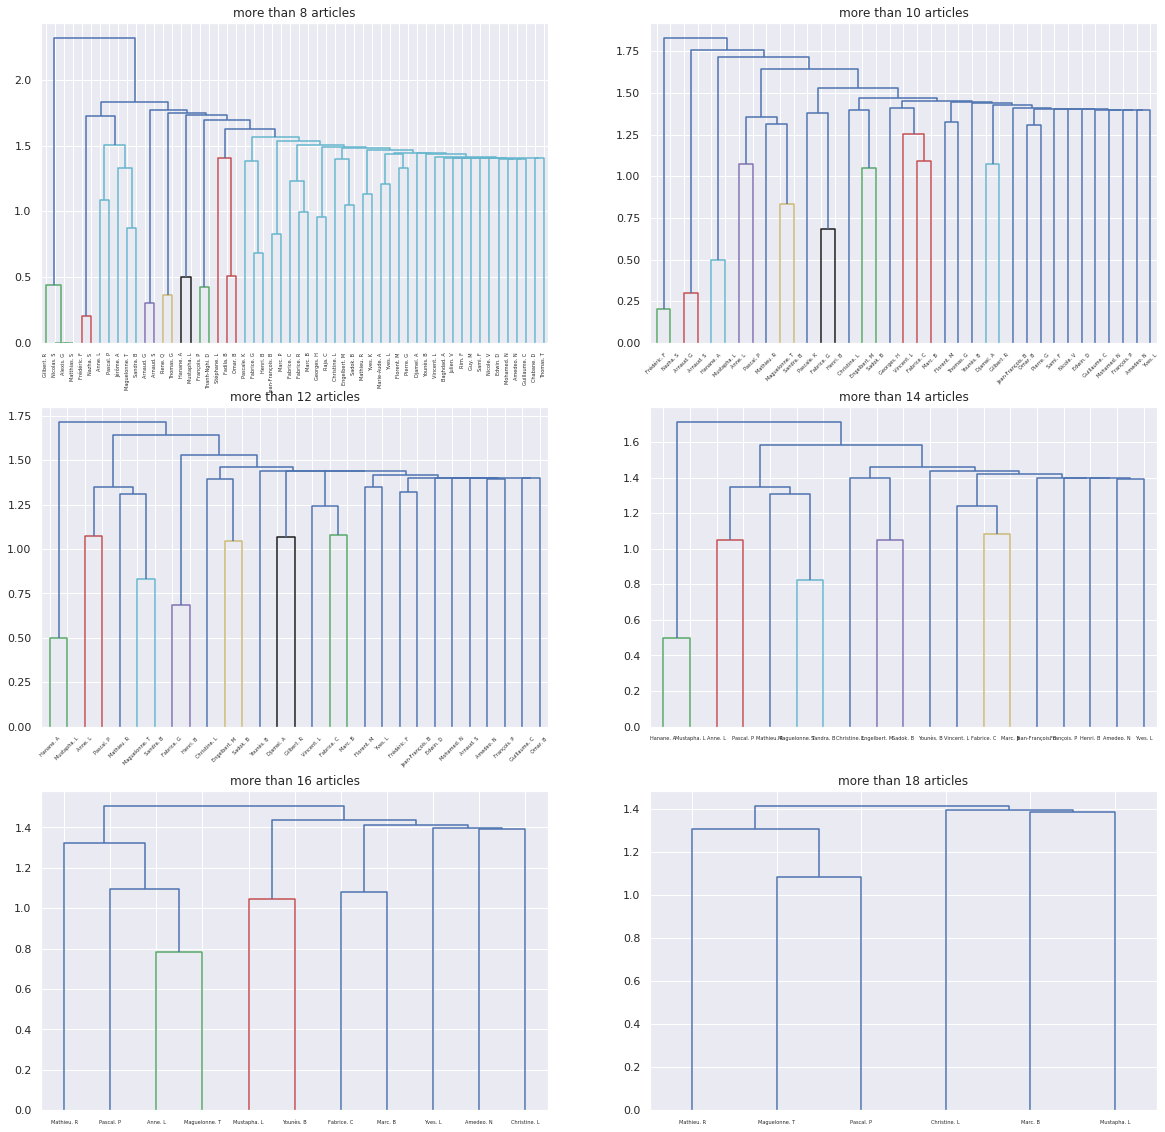

In [0]:
from matplotlib import pyplot as plt
from matplotlib import cm as cm
from scipy.cluster import hierarchy


threshold_frequency_dic = {}
# fig = plt.figure()
fig = plt.figure(figsize=(20, 20))
for i in range (0, 6):
  index = ((i+4)*2)
  df_authors_filtered = df_encoded_as_columns.loc[:, (df_encoded_as_columns.sum(axis=0) >= index )]
  print(df_authors_filtered.shape)
  threshold_frequency_dic[index] =df_authors_filtered.shape[1]
  c = df_authors_filtered.corr().abs()
  X = 1-c 
  Z = hierarchy.linkage(X, 'complete')
  ax1 = fig.add_subplot(3,2,i+1)
  ax1.title.set_text("more than " + str(index) + " articles")
  # cax = ax1.imshow(c, interpolation="nearest", cmap=cmap)
  dn = hierarchy.dendrogram(Z, leaf_font_size= 5, labels=[ str(s.split()[0]) + str(". ") + str(s.split()[1][0]) for s in X.index], show_contracted = True)
  ax1.grid(True)


# plt.savefig("dendrogram.png", dpi=500)

plt.savefig("dendrogram.png", dpi=500, facecolor='w', edgecolor='w')

Extra columns to extract new information

Wordcloud
citation
apriori